In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
import numpy as np
import pandas as pd

sys.path.append('../..')
import project
import project.validation
from project.core import utils

utils.set_verbose(False)
utils.log('hello, world')

In [6]:
%autoreload
ds = project.datasets.shapenet.ShapeNetDataset(data_root='../../data/ShapeNetSem')
len(ds.subjects())

12288

# Stage 1 - metadata validation

In [4]:
subjects = list(ds.subjects())
variant = 'TEST'

rows = []
for ex in tqdm.tqdm(list(ds.examples(subjects, variant))):
    rows.append(project.validation.validate_example(ex, metadata=True))

m = pd.DataFrame(rows)

NameError: name 'tqdm' is not defined

# Stage 2 - path validation

In [37]:
subjects = list(m[m.valid].subject)

row = []
for ex in tqdm.tqdm(list(ds.examples(subjects, variant))):
    rows.append(project.validation.validate_example(ex, paths=True))

p = pd.DataFrame(rows)

100%|██████████| 9260/9260 [27:19<00:00,  5.65it/s]  


In [57]:
df = m.merge(p, on='subject', how='inner')
df

,subject,metadata.category.set,metadata.category.len,metadata.category.valid,metadata.category.reasons,metadata.unit.value,metadata.unit.valid,metadata.unit.reasons,metadata.dims.shape,metadata.dims.value,...,paths.source_mesh.fsize,paths.source_mesh.valid,paths.source_mesh.reasons,paths.source_mask.exists,paths.source_mask.fsize,paths.source_mask.valid,paths.source_mask.reasons,paths.valid,paths.reasons,paths.source_mask.exc
0,wss.100f39dce7690f59efb94709f30ce0d2,"{Chair, Recliner}",2.0,True,(),0.012947,True,(),"(3,)","[111.34567, 100.547745, 96.13275]",...,95717.0,True,(),True,56778.0,True,(),True,(),NaN
1,wss.101354f9d8dede686f7b08d9de913afe,"{Speaker, _Attributes}",2.0,True,(),0.013620,True,(),"(3,)","[43.43313, 60.591843, 32.17259]",...,242527.0,True,(),True,52106.0,True,(),True,(),NaN
2,wss.1018f01d42ae7fad52249d8432f6087e,{Sword},1.0,True,(),0.010424,True,(),"(3,)","[78.23693, 4.360932, 18.058533]",...,1342220.0,True,(),True,17187.0,True,(),True,(),NaN
3,wss.1022fe7dd03f6a4d4d5ad9f13ac9f4e7,"{Chair, OfficeChair}",2.0,True,(),0.017984,True,(),"(3,)","[60.366123, 98.00925, 66.79712]",...,12347930.0,True,(),True,39138.0,True,(),True,(),NaN
4,wss.1028b32dc1873c2afe26a3ac360dbd4,"{Chair, OfficeSideChair}",2.0,True,(),0.036115,True,(),"(3,)","[78.41001, 117.685616, 77.54468]",...,982656.0,True,(),True,30383.0,True,(),True,(),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9255,wss.738cebb6eab9151bd4a8d9e46acec1f4,"{Lamp, WallLamp}",2.0,True,(),0.084080,True,(),"(3,)","[51.64453, 84.50152, 37.83612]",...,3040648.0,True,(),True,38352.0,True,(),True,(),NaN
9256,wss.571a3c2cf4c509596cb5b29312d0feee,"{Lamp, WallLamp}",2.0,True,(),0.069445,True,(),"(3,)","[69.44497, 39.93086, 69.44497]",...,129195.0,True,(),True,39694.0,True,(),True,(),NaN
9257,wss.1a6a520652aa2244146fa8a09fad6c38,"{Lamp, WallLamp}",2.0,True,(),0.087170,True,(),"(3,)","[52.854767, 69.972565, 59.619797]",...,722372.0,True,(),True,87.0,False,"(failed to load,)",False,"(failed to load,)",operands could not be broadcast together with ...
9258,wss.4ab745d5e834afd23765349fd8e5584,{CellPhone},1.0,True,(),0.006164,True,(),"(3,)","[10.935303, 4.3760524, 23.863827]",...,7221305.0,True,(),True,21259.0,True,(),True,(),NaN


In [4]:
csv_path = '2025-10-28_validate.csv'
#df.to_csv(csv_path)

# Stage 3 - artifact validation

In [7]:
import sys
import pandas as pd

sys.path.append('../../../param_search')
import param_search as ps

ps.set_verbose(False)
ps.set_backend('slurm')

In [8]:
csv_path = '2025-10-28_validate.csv'
val = pd.read_csv(csv_path, index_col=0)
subjects = list(val.subject)
N = len(subjects)
N

9260

In [9]:
base_dir = '2025-10-29_validate'

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 6:00:00
set -eo pipefail

source ~/.bashrc
LP=$PROJECT/lung-project

module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/validate.py --dataset shapenet --data_root $LP/data/ShapeNetSem --output {output_path} --subject {subject}

'''
name_format = '{params_hash}'

grid = [{'subject': ','.join(subjects[i:i+100])} for i in range(0, N, 100)]
len(grid)

93

In [25]:
base_dir = '2025-10-30_validate'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 6:00:00
set -eo pipefail

LP=$PROJECT/lung-project
mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/validate.py --dataset shapenet --data_root $LP/data/ShapeNetSem --output {output_path} --subject {subject}

'''
name_format = '{params_hash}'

grid = [{'subject': ','.join(subjects[i:i+100])} for i in range(0, N, 100)]
len(grid)

93

In [26]:
%autoreload
try:
    jobs = ps.setup(base_dir, template, name_format, grid, overwrite=False)
except OSError:
    jobs = ps.load(base_dir)
jobs

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,...,params.subject,output_exists,output_fsize,output_mtime,array_idx,last_live_at,state_source,finalized,finalized_at,error_line
0,0103f8f8d5c25bf7,COMPLETED,1,35732758,v010,01:00:49,├── 'components': 1\n└── 'angles': dic...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135...",True,105065,1.761871e+09,NaN,2025-10-30T20:22:34,history,True,2025-10-30T20:58:18,None
1,2c2a66a5b73cc06d,COMPLETED,1,35732759,v011,00:59:32,├── 'watertight': True\n├── 'components': ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.127aff49c9378499ae685ca100c909e8,wss.12811...",True,104921,1.761871e+09,NaN,2025-10-30T20:22:34,history,True,2025-10-30T20:58:18,None
2,b20663a8a1600460,COMPLETED,1,35732760,v024,01:24:05,├── 'watertight': True\n├── 'components': ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.14e4cb9d8fd5c29f60467dddaf5cfe3f,wss.14e5d...",True,105551,1.761872e+09,NaN,2025-10-30T20:58:18,history,True,2025-10-31T02:29:09,None
3,dfdacaf62ea4a0ad,COMPLETED,1,35732761,w003,02:57:11,\nAfter pymeshfix repair:\ndict(len=7)\n├── 'v...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.1730e6c6a37f19abefae06b5b9950833,wss.1741b...",True,104622,1.761879e+09,NaN,2025-10-30T20:58:18,history,True,2025-10-31T02:29:09,None
4,c93edace8ae2f554,COMPLETED,1,35732762,gl001,01:30:19,\nAfter pymeshfix repair:\ndict(len=7)\n├── 'v...,WARNING- 4 double-triangles have been removed....,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.198d36bcfacb1a7a4212ff51b27f0221,wss.19927...",True,103943,1.761874e+09,NaN,2025-10-30T20:58:18,history,True,2025-10-31T02:29:09,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,f342d995ff0b8b40,COMPLETED,1,35732846,v024,01:41:36,├── 'watertight': True\n├── 'components': ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.ffcc57ea3101d18ece3df8a7477638c0,wss.ffcf0...",True,105436,1.761885e+09,NaN,2025-10-30T20:58:18,history,True,2025-10-31T02:29:09,None
89,b4c4f77d0ea31b34,COMPLETED,1,35732847,gl001,00:44:02,4 4 4 4 4 4 3 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.32dc55c3e945384dbc5e533ab711fd24,wss.33d2a...",True,110986,1.761881e+09,NaN,2025-10-30T20:58:18,history,True,2025-10-31T02:29:09,None
90,bcdb4e7218d14874,COMPLETED,1,35732848,w003,00:55:55,├── 'watertight': True\n├── 'components': ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.66f56dc9a4751bded9651cd1d591d64d,wss.6730f...",True,110146,1.761882e+09,NaN,2025-10-30T20:58:18,history,True,2025-10-31T02:29:09,None
91,5c023e2f832d4dcf,COMPLETED,1,35732849,v026,00:51:43,├── 'watertight': True\n├── 'components': ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.a47cd8002c2f342b14513156cf2b8d0d,wss.a4d44...",True,110410,1.761882e+09,NaN,2025-10-30T20:58:18,history,True,2025-10-31T02:29:09,None


In [12]:
%autoreload
jobs = ps.recover(jobs)
jobs = ps.status(jobs)
jobs = ps.history(jobs)
jobs = ps.collect(jobs)
jobs

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,...,params.subject,array_idx,last_live_at,state_source,finalized,finalized_at,error_line,output_exists,output_fsize,output_mtime
0,0103f8f8d5c25bf7,COMPLETED,3,35682706,v004,00:31:56,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135...",NaN,None,history,True,2025-10-30T00:45:10,None,True,98406,1.761725e+09
1,2c2a66a5b73cc06d,COMPLETED,3,35682707,v009,00:38:33,artifacts.binvox.clean.max ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.127aff49c9378499ae685ca100c909e8,wss.12811...",NaN,None,history,True,2025-10-30T00:45:10,None,True,98248,1.761725e+09
2,b20663a8a1600460,COMPLETED,3,35682708,v012,00:45:15,artifacts.binvox.clean.thickness_p50 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.14e4cb9d8fd5c29f60467dddaf5cfe3f,wss.14e5d...",NaN,None,history,True,2025-10-30T00:45:10,None,True,99076,1.761726e+09
3,dfdacaf62ea4a0ad,COMPLETED,3,35682709,v019,01:54:57,artifacts.binvox.clean.min ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.1730e6c6a37f19abefae06b5b9950833,wss.1741b...",NaN,None,history,True,2025-10-30T00:45:10,None,True,97882,1.761730e+09
4,c93edace8ae2f554,COMPLETED,3,35682710,v024,00:42:05,artifacts.binvox.clean.min ...,WARNING- 4 double-triangles have been removed....,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.198d36bcfacb1a7a4212ff51b27f0221,wss.19927...",NaN,None,history,True,2025-10-30T00:45:10,None,True,97349,1.761725e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,f342d995ff0b8b40,COMPLETED,2,35682794,w010,00:39:43,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.ffcc57ea3101d18ece3df8a7477638c0,wss.ffcf0...",NaN,None,history,True,2025-10-30T00:45:10,None,True,104799,1.761728e+09
89,b4c4f77d0ea31b34,COMPLETED,3,35725543,v009,00:25:12,4 4 4 4 4 4 3 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.32dc55c3e945384dbc5e533ab711fd24,wss.33d2a...",NaN,2025-10-30T01:35:37,history,True,2025-10-30T02:22:15,None,True,110296,1.761805e+09
90,bcdb4e7218d14874,COMPLETED,2,35682796,v020,00:38:49,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.66f56dc9a4751bded9651cd1d591d64d,wss.6730f...",NaN,None,history,True,2025-10-30T00:45:10,None,True,109315,1.761728e+09
91,5c023e2f832d4dcf,COMPLETED,2,35682797,w005,00:17:15,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.a47cd8002c2f342b14513156cf2b8d0d,wss.a4d44...",NaN,None,history,True,2025-10-30T00:45:10,None,True,109598,1.761727e+09


In [18]:
jobs.groupby(['job_state']).count()

,job_name,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,script_path,...,params.subject,output_exists,output_fsize,output_mtime,array_idx,last_live_at,state_source,finalized,finalized_at,error_line
job_state,,,,,,,,,,,,,,,,,,,,,
COMPLETED,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,0,93,93,93,93,0


In [19]:
# mark failed jobs for resubmit
sel = (jobs['job_state'] == 'FAILED')
jobs.loc[sel, 'job_id'] = pd.NA
jobs.loc[jobs['job_id'].isna()]

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,...,params.subject,output_exists,output_fsize,output_mtime,array_idx,last_live_at,state_source,finalized,finalized_at,error_line


In [20]:
%autoreload
jobs = ps.submit(jobs)

# Validation outputs

In [27]:
df = ps.outputs(jobs, skip_errors=False)
df

,subject,metadata.category.set,metadata.category.len,metadata.category.set_f,metadata.category.len_f,metadata.category.valid,metadata.category.reasons,metadata.unit.value,metadata.unit.valid,metadata.unit.reasons,...,artifacts.reasons,valid,reasons,artifacts.scene.exc,paths.source_mask.exc,source_path,job_name,job_id,params_hash,params.subject
0,wss.100f39dce7690f59efb94709f30ce0d2,"{'Recliner', 'Chair'}",2,"{'Recliner', 'Chair'}",2,True,(),0.012947,True,(),...,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,0103f8f8d5c25bf7,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135..."
1,wss.101354f9d8dede686f7b08d9de913afe,"{'Speaker', '_Attributes'}",2,{'Speaker'},1,True,(),0.013620,True,(),...,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,0103f8f8d5c25bf7,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135..."
2,wss.1018f01d42ae7fad52249d8432f6087e,{'Sword'},1,{'Sword'},1,True,(),0.010424,True,(),...,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,0103f8f8d5c25bf7,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135..."
3,wss.1022fe7dd03f6a4d4d5ad9f13ac9f4e7,"{'OfficeChair', 'Chair'}",2,"{'OfficeChair', 'Chair'}",2,True,(),0.017984,True,(),...,"('single geometry',)",False,"('single geometry',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,0103f8f8d5c25bf7,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135..."
4,wss.1028b32dc1873c2afe26a3ac360dbd4,"{'OfficeSideChair', 'Chair'}",2,"{'OfficeSideChair', 'Chair'}",2,True,(),0.036115,True,(),...,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,0103f8f8d5c25bf7,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9255,wss.738cebb6eab9151bd4a8d9e46acec1f4,"{'Lamp', 'WallLamp'}",2,"{'Lamp', 'WallLamp'}",2,True,(),0.084080,True,(),...,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,8786de37533664e5,35732850,8786de37533664e5,"wss.eddefff6f7f36ac333b5f1127fe70646,wss.ee4a8..."
9256,wss.571a3c2cf4c509596cb5b29312d0feee,"{'Lamp', 'WallLamp'}",2,"{'Lamp', 'WallLamp'}",2,True,(),0.069445,True,(),...,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,8786de37533664e5,35732850,8786de37533664e5,"wss.eddefff6f7f36ac333b5f1127fe70646,wss.ee4a8..."
9257,wss.1a6a520652aa2244146fa8a09fad6c38,"{'Lamp', 'WallLamp'}",2,"{'Lamp', 'WallLamp'}",2,True,(),0.087170,True,(),...,"('missing binvox',)",False,"('missing dims', 'failed to load', 'missing bi...",NaN,operands could not be broadcast together with ...,/ocean/projects/asc170022p/mtragoza/lung-proje...,8786de37533664e5,35732850,8786de37533664e5,"wss.eddefff6f7f36ac333b5f1127fe70646,wss.ee4a8..."
9258,wss.4ab745d5e834afd23765349fd8e5584,{'CellPhone'},1,{'CellPhone'},1,True,(),0.006164,True,(),...,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,8786de37533664e5,35732850,8786de37533664e5,"wss.eddefff6f7f36ac333b5f1127fe70646,wss.ee4a8..."


In [29]:
meta_cols = [c for c in df.columns if c.startswith('metadata')]
path_cols = [c for c in df.columns if c.startswith('paths')]
art_cols = [c for c in df.columns if c.startswith('artifacts')]
[c for c in df.columns if c not in set(meta_cols + path_cols + art_cols)]

['subject',
 'valid',
 'reasons',
 'source_path',
 'job_name',
 'job_id',
 'params_hash',
 'params.subject']

In [30]:
df.groupby(['valid', 'reasons'])[['subject']].count()

subject
valid reasons                                                    
False ('failed to load', 'missing binvox')                    288
      ('failed to load', 'single geometry', 'missing ...       65
      ('failed to load', 'single geometry', 'zero vol...        2
      ('failed to load', 'zero volume', 'missing mesh...       11
      ('missing dims', 'all zero voxels', 'all zero v...        6
      ('missing dims', 'failed to load', 'missing bin...       17
      ('missing dims', 'failed to load', 'single geom...        6
      ('missing dims', 'single geometry')                     691
      ('missing dims', 'single geometry', 'all zero v...        4
      ('missing dims', 'single geometry', 'zero volum...       15
      ('missing dims', 'single geometry', 'zero volum...        1
      ('missing dims', 'single geometry', 'zero volum...       28
      ('missing dims', 'single geometry', 'zero volum...        7
      ('missing dims', 'zero volume', 'fewer than 4 v...        4
      ('missing dims', 'zero volume', 'missing mesh')         112
      ('missing dims', 'zero volume', 'missing mesh',...        2
      ('missing dims', 'zero volume', 'zero volume')            4
      ('missing dims',)                                      5263
      ('single geometry', 'all zero voxels', 'all zer...        4
      ('single geometry', 'zero volume', 'fewer than ...        5
      ('single geometry', 'zero volume', 'missing mesh')        7
      ('single geometry',)                                    289
      ('zero volume', 'fewer than 4 vertices')                  6
      ('zero volume', 'fewer than 4 vertices', 'all z...        1
      ('zero volume', 'missing mesh')                          50
      ('zero volume', 'missing mesh', 'all zero voxel...        1
      ('zero volume', 'zero volume')                            2
True  ()                                                     2369

In [31]:
def parse_vector(x):
    import numpy as np
    assert x[0] == '[' and x[-1] == ']'
    parts = x[1:-1].split()
    return np.array([float(v) for v in parts])

def rel_error(a, b):
    from numpy.linalg import norm
    return norm(a - b) / norm(b)

sel = df['metadata.valid']
errors = []
for i, row in df[sel].iterrows():
    subj = row['subject']
    unit = row['metadata.unit.value']
    dims = parse_vector(row['metadata.dims.xyz_m'])
    extent = parse_vector(row['artifacts.scene.mesh.extent'])
    error = rel_error(dims, extent * unit)
    errors.append(error)

df.loc[sel, 'dims_error'] = errors
df[['dims_error']].describe().T

,count,mean,std,min,25%,50%,75%,max
dims_error,3100.0,0.114529,0.282709,3.137238e-09,3.702846e-08,6.458294e-08,2.218254e-07,1.354071


In [32]:
df.groupby([
    'metadata.valid',
    'metadata.category.reasons',
    'metadata.unit.reasons',
    'metadata.dims.reasons'
])[['subject']].count()

,,,,subject
metadata.valid,metadata.category.reasons,metadata.unit.reasons,metadata.dims.reasons,
False,(),(),"('missing dims',)",6160
True,(),(),(),3100


In [33]:
df.groupby([
    'paths.valid',
    'paths.source_mesh.reasons',
    'paths.source_mask.reasons'
])[['subject']].count()

,,,subject
paths.valid,paths.source_mesh.reasons,paths.source_mask.reasons,
False,(),"('failed to load',)",389
True,(),(),8871


In [34]:
df.groupby([
    'artifacts.valid',
    'artifacts.scene.mesh.reasons',
    'artifacts.scene.repair.reasons',
    'artifacts.binvox.array.reasons',
    'artifacts.binvox.clean.reasons'
])[['subject']].count()

subject
artifacts.valid artifacts.scene.mesh.reasons artifacts.scene.repair.reasons artifacts.binvox.array.reasons artifacts.binvox.clean.reasons         
False           ('zero volume',)             ('fewer than 4 vertices',)     ('all zero voxels',)           ('all zero voxels',)                  2
                                                                            ()                             ()                                   30
                                             ('missing mesh',)              ('all zero voxels',)           ('all zero voxels',)                 10
                                                                            ()                             ('one nonzero voxel',)                1
                                                                                                           ()                                  196
                                             ('zero volume',)               ()                             ()                                    6
                                             ()                             ('all zero voxels',)           ('all zero voxels',)                  9
                                                                            ()                             ()                                  481
                ()                           ('fewer than 4 vertices',)     ()                             ()                                    2
                                             ('missing mesh',)              ('all zero voxels',)           ('all zero voxels',)                  2
                                                                            ()                             ()                                   21
                                             ()                             ('all zero voxels',)           ('all zero voxels',)                  3
                                                                            ()                             ()                                  476
True            ('zero volume',)             ()                             ()                             ()                                 3003
                ()                           ('fewer than 4 vertices',)     ()                             ()                                   30
                                             ('missing mesh',)              ()                             ()                                  249
                                             ('zero volume',)               ()                             ()                                    2
                                             ()                             ()                             ()                                 4348

1116 12.051835853131749 31.09318996415771


<Axes: ylabel='Frequency'>

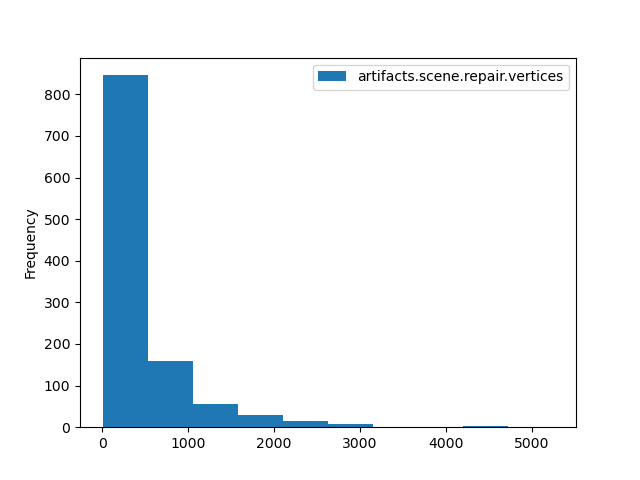

In [66]:
CATEGORY_BLACKLIST = {'Room', 'Courtyard'}

def check_category_set(x):
    import ast
    return not (ast.literal_eval(x) & CATEGORY_BLACKLIST)

m = (
    #df['valid'] &
    #(df['metadata.valid']) &
    #(df['dims_error'] < 1e-2) &
    (df['paths.valid']) &
    (df['artifacts.valid']) &
    (df['artifacts.scene.geometries'] >= 1) &
    (df['artifacts.scene.geometries'] <= 10) &
    (df['artifacts.scene.mesh.vertices'] > 100) &
    (df['artifacts.scene.mesh.vertices'] < 50000) &
    (df['artifacts.scene.repair.watertight']) &
    (df['artifacts.scene.repair.volume'] > 8**3) &
    (df['artifacts.scene.repair.convexity'] > 0.5) &
    (df['artifacts.scene.repair.components'] == 1) &
    (df['artifacts.binvox.clean.components'] == 1) &
    (df['artifacts.binvox.clean.nonzero'] > 16**3) &
    #(df['artifacts.binvox.clean.thickness_p5'] >= 2) &
    (df['artifacts.binvox.clean.thickness_p50'] >= 4) &
    (df['metadata.category.set']).map(check_category_set) &
    True
)
print(m.sum(), m.mean() * 100, df[m].valid.mean() * 100)

df.loc[m, ['artifacts.scene.repair.vertices']].plot.hist()

In [70]:
%ls

00-validation.ipynb      2025-10-28_validate.csv.backup
01-preprocessing.ipynb   2025-10-29_validate/
02-fem-simulation.ipynb  2025-10-30_validate/
2025-10-28_validate.csv  texture_annotations_2025-10-21.csv


In [73]:
df.loc[m, [c for c in df.columns if not c.startswith('params')]].to_csv('2025-11-02_selected.csv', index=False)

In [84]:
%autoreload
examples = list(ds.examples(df.loc[m, 'subject'].tolist(), variant='TEST'))
len(examples)

1122

In [86]:
ex = examples[0]
utils.pprint(ex)

Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.100f39dce7690f59efb94709f30ce0d2'
├── variant:  'TEST'
├── paths:    dict(len=12)
|   ├── 'source_mesh':   PosixPath('../../data/ShapeNetSem/models-OBJ/models/100f39dce7690f59efb94709f30ce0d2.obj')
|   ├── 'source_mask':   PosixPath('../../data/ShapeNetSem/models-binvox-solid/100f39dce7690f59efb94709f30ce0d2.binvox')
|   ├── 'surface_mesh':  PosixPath('../../data/ShapeNetSem/TEST/100f39dce7690f59efb94709f30ce0d2/meshes/surface.xdmf')
|   ├── 'binary_mask':   PosixPath('../../data/ShapeNetSem/TEST/100f39dce7690f59efb94709f30ce0d2/masks/binary.nii.gz')
|   ├── 'region_mask':   PosixPath('../../data/ShapeNetSem/TEST/100f39dce7690f59efb94709f30ce0d2/masks/regions.nii.gz')
|   ├── 'volume_mesh':   PosixPath('../../data/ShapeNetSem/TEST/100f39dce7690f59efb94709f30ce0d2/meshes/volume.xdmf')
|   ├── 'material_mask': PosixPath('../../data/ShapeNetSem/TEST/100f39dce7690f59efb94709f30ce0d2/masks/material.nii.gz')
|   ├── 'density_field': Posix

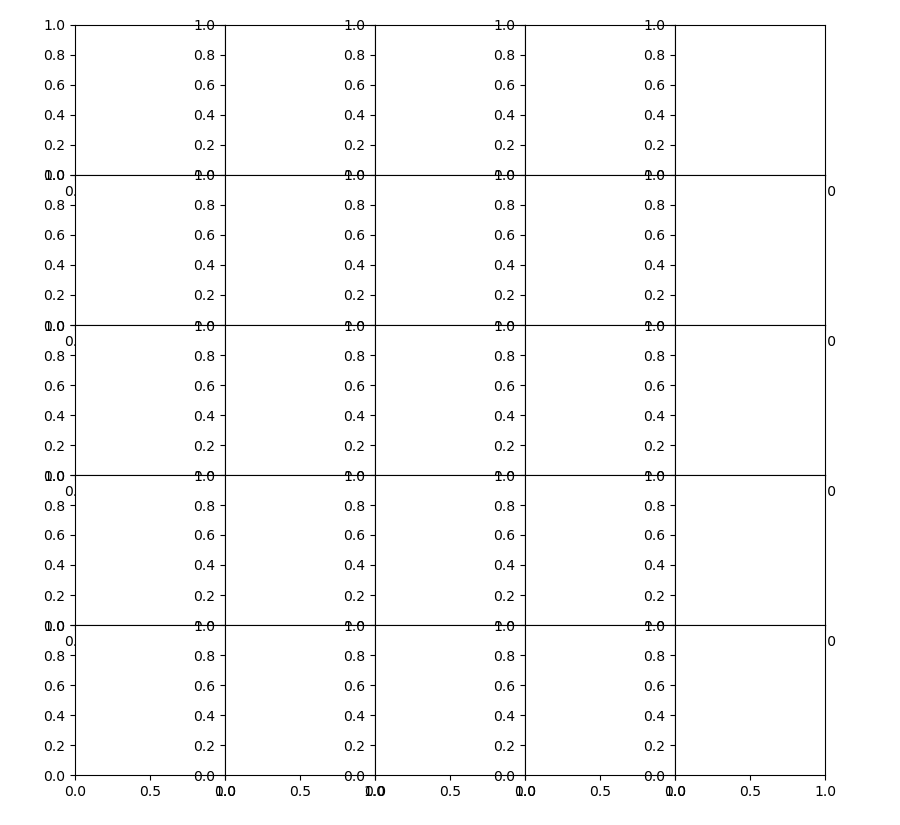

In [91]:
def show_thumbnails(examples, n_rows=5, n_cols=5):
    from project.visual.matplotlib import subplot_grid

    fig, axes = subplot_grid(
        n_rows, n_cols,
        ax_height=1.5,
        ax_width=1.5,
        spacing=(0., 0.), # hw
        padding=(0.75, 0.75, 0.5, 0.25), # lrbt
    )
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i,j]
            
            a = np.eye(10)
            ax.imshow(a, cmap='gray', extent=(0, W - 1, 0, H - 1))

        for j in range(j+1, n_cols):
            axes[i,j].axis('off')

    return fig

show_thumbnails(examples)